- - -

#### _Extracting lineage metrics from PhysiCell output for informed ABM development._

- - -

_Citations:_

elmar bucher, godzilla-but-nicer, Randy Heiland, Paul Macklin, & Patrick G Wall. (2023). elmbeech/physicelldataloader: 2023-07-23 (v3.2.9). Zenodo. https://doi.org/10.5281/zenodo.8176400

Ghaffarizadeh, A., Heiland, R., Friedman, S. H., Mumenthaler, S. M., & Macklin, P. (2018). PhysiCell: An open source physics-based cell simulator for 3-D multicellular systems. PLoS computational biology, 14(2), e1005991.

Ghaffarizadeh, A., Friedman, S. H., & Macklin, P. (2016). BioFVM: an efficient, parallelized diffusive transport solver for 3-D biological simulations. Bioinformatics, 32(8), 1256-1258.

- - -

# Install libraries

In [36]:
# for loading PhysiCell output
## !pip3 install -U pcdl[all]

# for data visualization
## !pip3 install plotly==5.22.0
## !pip3 install pygraphviz

# for HTML output
## !pip install jinja2==3.0.3
## !pip install nbconvert==6.4.4
## !pip install pretty-jupyter 

%load_ext pretty_jupyter

The pretty_jupyter extension is already loaded. To reload it, use:
  %reload_ext pretty_jupyter


# Load libraries

In [1]:
import pcdl

import numpy as np
import pandas as pd

from sklearn.decomposition import PCA

import json

import ipykernel # for debugging
from IPython.display import display, HTML

from scipy.spatial import KDTree

import plotly.express as px
import plotly.graph_objects as go

import plotly.io as pio
pio.renderers.default = "notebook"


import networkx as nx

import collections

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation


# Load data

Output is in `../../output_ffdd1e6s_heterogeneity`.

In [2]:
# -.-|m { output: false }

output_path = "../../output_ffdd1e6_heterogeneity"

# MultiCellular Data Standard // https://www.biorxiv.org/content/10.1101/090456v2

# TimeSeries -- the entirety of the simulation
mcds_ts = pcdl.TimeSeries(output_path) 
all_mcds = mcds_ts.read_mcds()
# TimeStep -- a "snapshot" of the simulation
# mcds = pcdl.TimeStep(file_48_path)

reading: ../../output_ffdd1e6_heterogeneity/PhysiCell_settings.xml
Warning @ pyMCDS._read_xml : cell_definition custom_data without variable type setting detected. ['oncoprotein']
reading: ../../output_ffdd1e6_heterogeneity/output00000000.xml
working on metadata ...
working on mesh data ...
reading: ../../output_ffdd1e6_heterogeneity/initial_mesh0.mat
working on microenvironment data ...
reading: ../../output_ffdd1e6_heterogeneity/output00000000_microenvironment0.mat
parsing: oxygen data
working on discrete cell data ...
reading: ../../output_ffdd1e6_heterogeneity/output00000000_cells.mat
working on graph data ...
reading: ../../output_ffdd1e6_heterogeneity/output00000000_cell_neighbor_graph.txt
reading: ../../output_ffdd1e6_heterogeneity/output00000000_attached_cells_graph.txt
done!

reading: ../../output_ffdd1e6_heterogeneity/PhysiCell_settings.xml
Warning @ pyMCDS._read_xml : cell_definition custom_data without variable type setting detected. ['oncoprotein']
reading: ../../output_ff

In [8]:
mcds_140 = all_mcds[140]

print(mcds_140.get_time())

8400.0


# Prepare data

In [9]:
# variables that have only 1 state carry no information, 
# so output variables with at least 2 states

df_cell = mcds_140.get_cell_df(states=2)

In [10]:
display(df_cell)

,cell_count_voxel,cell_density_micron3,current_cycle_phase_exit_rate,current_death_model,current_phase,cycle_model,cytoplasmic_biomass_change_rate,cytoplasmic_volume,dead,death_rates_1,...,surface_area,target_fluid_fraction,target_solid_cytoplasmic,target_solid_nuclear,time,total_volume,tree_ID,voxel_i,voxel_j,voxel_k
ID,,,,,,,,,,,,,,,,,,,,,
0,3,0.000375,0.000012,1,necrotic_lysed,necrosis_death_model,0.000053,317.986883,True,9.000000e+99,...,225.297789,0.00,0.0,0.0,8400.0,317.986884,0.0,49,49,0
1,1,0.000125,0.000012,1,necrotic_lysed,necrosis_death_model,0.000053,317.986883,True,9.000000e+99,...,225.297789,0.00,0.0,0.0,8400.0,317.986884,1.0,50,50,0
2,3,0.000375,0.000004,0,live,live_cells_cycle_model,0.004500,1954.000000,False,0.000000e+00,...,889.368528,0.75,488.5,135.0,8400.0,2494.000000,2.0,49,49,0
3,3,0.000375,0.000003,0,live,live_cells_cycle_model,0.004500,1954.000000,False,0.000000e+00,...,889.368528,0.75,488.5,135.0,8400.0,2494.000000,3.0,51,49,0
1076,1,0.000125,0.000132,0,live,live_cells_cycle_model,0.004500,1954.000000,False,0.000000e+00,...,889.368528,0.75,488.5,135.0,8400.0,2494.000000,1076.3,53,36,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1355,1,0.000125,0.000131,0,live,live_cells_cycle_model,0.004500,1112.874365,False,0.000000e+00,...,614.116200,0.75,488.5,135.0,8400.0,1431.032984,1355.2,64,54,0
1356,2,0.000250,0.000132,0,live,live_cells_cycle_model,0.004500,1098.338160,False,0.000000e+00,...,608.561027,0.75,488.5,135.0,8400.0,1411.659703,1356.4,52,62,0
1357,1,0.000125,0.000147,0,live,live_cells_cycle_model,0.004500,1020.558890,False,0.000000e+00,...,577.963752,0.75,488.5,135.0,8400.0,1306.546034,1357.2,36,46,0


In [13]:
df_cell = df_cell.astype({"generation": int})
df_cell = df_cell[["generation", "tree_ID", "parent_ID"]].sort_index()
display(df_cell)


,generation,tree_ID,parent_ID
ID,,,
0,0,0.0,-1.0
1,0,1.0,-1.0
2,0,2.0,-1.0
3,0,3.0,-1.0
5,0,5.0,-1.0
...,...,...,...
1357,2,1357.2,1037.1
1358,2,1358.2,323.1
1359,1,1359.1,740.0


In [19]:
unique_tree_IDs = df_cell["tree_ID"].unique()
np.set_printoptions(suppress=True)
unique_tree_IDs

array([   0. ,    1. ,    2. ,    3. ,    5. ,    6. ,    7. ,    8. ,
          9. ,   13. ,   15. ,   16. ,   17.1,   20. ,   23. ,   25. ,
         26. ,   27. ,   28.2,   29. ,   30.2,   31. ,   33. ,   34. ,
         35. ,   36. ,   37. ,   38. ,   39. ,   41. ,   42. ,   45. ,
         48. ,   49. ,   51. ,   52.1,   53. ,   54. ,   55.1,   56. ,
         58. ,   62. ,   63. ,   64. ,   65.2,   66. ,   67. ,   70. ,
         72.1,   75. ,   76.2,   80. ,   81.2,   82.1,   83. ,   84.3,
         85. ,   87. ,   88.1,   91.3,   93. ,   94. ,   95. ,   96. ,
         97. ,   98. ,  100. ,  101. ,  102. ,  103. ,  104. ,  105. ,
        106. ,  109. ,  110. ,  111. ,  112. ,  117. ,  118. ,  119. ,
        123.1,  125. ,  126. ,  127. ,  128.1,  129.2,  130. ,  131.1,
        132.1,  137.1,  139. ,  140. ,  141.1,  142. ,  143. ,  144.1,
        145. ,  146.1,  147. ,  148. ,  149. ,  150.2,  151. ,  153.1,
        154.1,  157.1,  160. ,  161. ,  162. ,  163. ,  164. ,  165. ,
      

In [79]:
ad = []

for timestep in all_mcds:
    time = timestep.data['metadata']['current_time']
    df = timestep.get_cell_df()
    df = df.loc[((df['parent_ID'] >= 0.0) & (df['parent_ID'] <= 50.0)) | ((df['parent_ID'] >= 900.0) & (df['parent_ID'] <= 1000.0)) | (df['tree_ID'] == 911.0)]
    df['time'] = time
    ad.append(df)

select_cells_lineage = pd.concat(ad)
display(select_cells_lineage)

select_cells_lineage.to_csv("out_het.csv")

,attachment_elastic_constant,attachment_rate,calcification_rate,calcified_fraction,cancer_cell_attack_rates,cancer_cell_cell_adhesion_affinities,cancer_cell_fusion_rates,cancer_cell_live_phagocytosis_rates,cancer_cell_transformation_rates,cell_BM_adhesion_strength,...,total_attack_time,total_volume,tree_ID,velocity_vectorlength,velocity_x,velocity_y,velocity_z,voxel_i,voxel_j,voxel_k
ID,,,,,,,,,,,,,,,,,,,,,
901,0.01,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,4.00,...,0.00,1186.38,901.20,0.00,0.00,0.00,0.00,38,53,0
920,0.01,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,4.00,...,0.00,1186.38,920.20,0.00,0.00,0.00,0.00,38,54,0
920,0.01,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,4.00,...,0.00,1408.00,920.20,0.00,0.00,0.00,0.00,38,54,0
901,0.01,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,4.00,...,0.00,1408.00,901.20,0.00,0.00,0.00,0.00,38,53,0
922,0.01,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,4.00,...,0.00,850.76,922.20,0.00,0.00,0.00,0.00,60,56,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
911,0.01,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,4.00,...,0.00,2493.45,911.30,0.00,0.00,0.00,0.00,58,48,0
912,0.01,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,4.00,...,0.00,206.26,912.20,0.00,0.00,0.00,0.00,41,54,0
969,0.01,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,4.00,...,0.00,2493.90,969.20,0.00,0.00,0.00,0.00,44,60,0


In [77]:
# color_dict = {"bacteria": "grey", "blood_vessel": "red", "stem": "yellow", "differentiated": "green", "macrophage": "blue", "CD8+_T_cell": "magenta", "neutrophil": "orange"}

def create_cell_ancestry(df):
    df = df.drop(df.loc[(df['parent_ID'] == -1) & (df['tree_ID'] != 911.0)].index)

    G = nx.from_pandas_edgelist(df, source='parent_ID', target='tree_ID', create_using=nx.DiGraph())

    pos = nx.drawing.nx_agraph.graphviz_layout(G, prog='dot')
    # nx.draw(G, pos, with_labels=True, node_size=2, arrows=True, font_size=3, node_color="lightblue")
    nx.draw(G, pos, node_size=2, with_labels=True, font_size=3, arrows=True, node_color="#91278f", edge_color="#938989")
    plt.savefig("lineage_selected_het.pdf")

    # T = nx.draw_spring(G, node_size=5, with_labels=True)

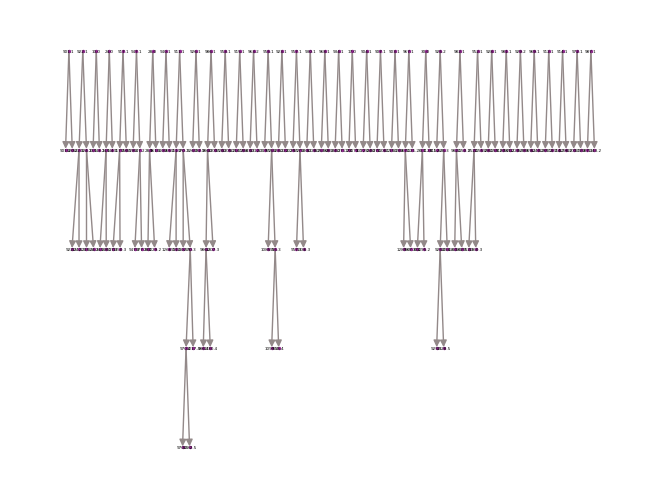

In [78]:
create_cell_ancestry(select_cells_lineage.copy())

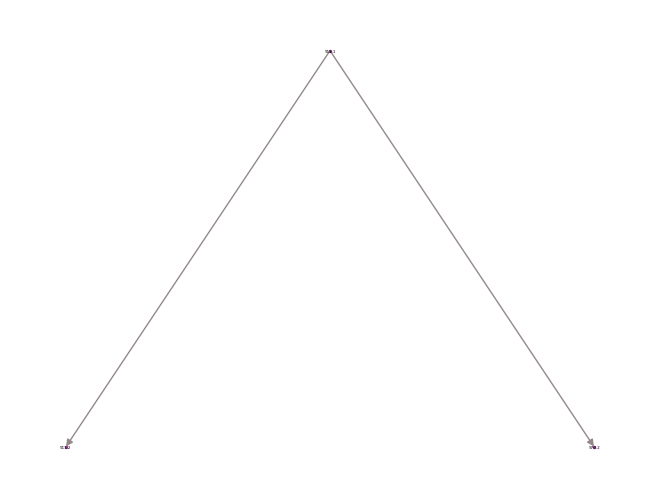

In [74]:
create_cell_ancestry(select_cells_lineage.loc[(select_cells_lineage['parent_ID'] == 911.1)])